In [1]:
import os
import tifffile
import rasterio

import cv2
import numpy as np

import leafmap.leafmap as leafmap
#from samgeo import SamGeo2

import geopandas as gpd
import pickle
from pyproj import Transformer

from utils.raster_tools import Raster_profile 
import matplotlib.pyplot as plt

### See the overall

In [2]:
clipped_theos_file = "theos/clipped_IMG_T2V_20250119034323_ORTHO_PMS_32.tif"

# m = leafmap.Map(center=[(lat_start + lat_end)/2, (long_start + long_end)/2], zoom=16, height="800px")
m = leafmap.Map(center=[12.908807, 100.922147], zoom=16, height="800px")
m.add_basemap("Satellite") 
m.add_raster(clipped_theos_file, layer_name="Theos") 
m

Map(center=[12.910632, 100.920771], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

## Read the cliped Google image

In [3]:
theos_Profile = Raster_profile(clipped_theos_file) 

Dataset name: theos/clipped_IMG_T2V_20250119034323_ORTHO_PMS_32.tif
File mode: r
Number of bands: 4
Image width: 15001 pixels
Image height: 14001 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 14001, 15001)
Data type: uint16


### Specify the grid's spacing

In [4]:
from pyproj import Transformer
import csv

def setup_polygon(long_start, lat_start, long_end, lat_end, crs_source="EPSG:4326", crs_target="EPSG:32647"): 
    bbox = [long_start, lat_start, long_end, lat_end] 
    coordinates = [
        [bbox[0], bbox[3]],  # Top-left corner (min_lon, max_lat)
        [bbox[2], bbox[3]],  # Top-right corner (max_lon, max_lat)
        [bbox[2], bbox[1]],  # Bottom-right corner (max_lon, min_lat)
        [bbox[0], bbox[1]],  # Bottom-left corner (min_lon, min_lat)
        [bbox[0], bbox[3]]   # Closing the polygon by repeating the first point
        ]

    transformer = Transformer.from_crs(crs_source, crs_target, always_xy=True)
    poly_gons = []
    for coord in coordinates: 
        easting, northing = transformer.transform(coord[0], coord[1])
        poly_gons.append([easting, northing])

    return poly_gons, bbox, coordinates

def save_stats(stats, path_npz, path_csv):
    np.savez(path_npz, **stats)

    with open(path_csv, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(['Key', 'Value'])
        # Write data line by line
        for key, value in stats.items():
            writer.writerow([key, value])
            
def read_npz(npz_filename):
    read_stats = dict(np.load(npz_filename))

    read_dict = {}
    for key, value in read_stats.items():
        try:
            read_dict[key] = value.item() 
        except:
            read_dict[key] = value

    return read_dict

In [5]:
long_start, lat_start = theos_Profile.get_longlat_from_image_pixels(0, 0, crs_dst="EPSG:4326")

In [6]:
zoom_level = 18
long_diff = 2*np.abs(100.9261026816609 - 100.9230026816609)
lat_diff  =  2*np.abs(13.054297390119896 - 13.052397390099848)
crs_source = "EPSG:4326"
crs_target = "EPSG:32647"

In [7]:
slice_no   = 0

slices_path = "ISP0704-Zoom%d" % zoom_level
slice_subpath  = os.path.join(slices_path, "%0000d" % slice_no)
slice_google_filename = os.path.join(slices_path, "%0000d" % slice_no, "google.tif") 
warped_slice_google_filename = os.path.join(slices_path, "%0000d" % slice_no, "warped_google.tif") 
slice_theos_filename  = os.path.join(slices_path, "%0000d" % slice_no, "theos.tif") 
npz_filename  = os.path.join(slices_path, "%0000d" % slice_no, "stats.npz") 
csv_filename = os.path.join(slices_path, "%0000d" % slice_no, "stats.csv") 

os.makedirs(slices_path, exist_ok=True)
os.makedirs(slice_subpath, exist_ok=True)

long_start_temp = long_start + (slice_no)*long_diff.item()  
lat_start_temp  = lat_start  - (slice_no)*lat_diff.item()

long_end_temp = long_start + (slice_no+1)*long_diff.item()  
lat_end_temp  = lat_start  - (slice_no+1)*lat_diff.item()

print("Slice no. %0000d" % slice_no) 
print("Start: LON: %f LAT: %f" % (long_start_temp, lat_start_temp)) 
print("End  : LON: %f LAT: %f" % (long_end_temp, lat_end_temp)) 

poly_gons, bbox, coordinates = setup_polygon(long_start_temp, lat_start_temp, long_end_temp, lat_end_temp, crs_source=crs_source, crs_target=crs_target)

leafmap.map_tiles_to_geotiff(output=slice_google_filename, bbox=bbox, zoom=zoom_level, source="Satellite", overwrite=True)
leafmap.clip_image(clipped_theos_file, poly_gons, slice_theos_filename)


stats = {"slice_no": slice_no, 
        "slice_theos_filename": slice_theos_filename,
        "slice_google_filename": slice_google_filename,  
        "long_start_temp": long_start_temp,
        "lat_start_temp": lat_start_temp,
        "long_end_temp": long_end_temp,
        "lat_end_temp": lat_end_temp,
        "poly_gons": poly_gons,
        "bbox":bbox,
        "coordinates": coordinates,
        "crs_source": crs_source,
        "crs_target": crs_target,
        "long_diff": long_diff,
        "lat_diff": lat_diff}

save_stats(stats, npz_filename, csv_filename)

Slice no. 0
Start: LON: 100.886455 LAT: 12.942518
End  : LON: 100.892655 LAT: 12.938718
Downloaded image 1/20
Downloaded image 2/20
Downloaded image 3/20
Downloaded image 4/20
Downloaded image 5/20
Downloaded image 6/20
Downloaded image 7/20
Downloaded image 8/20
Downloaded image 9/20
Downloaded image 10/20
Downloaded image 11/20
Downloaded image 12/20
Downloaded image 13/20
Downloaded image 14/20
Downloaded image 15/20
Downloaded image 16/20
Downloaded image 17/20
Downloaded image 18/20
Downloaded image 19/20
Downloaded image 20/20
Saving GeoTIFF. Please wait...
Image saved to ISP0704-Zoom18/0/google.tif


Reading input: /mnt/HDD2/GISTDA_workspace/geo/Building_detection/ISP0704-Zoom18/0/theos.tif

Adding overviews...
Updating dataset tags...
Writing output to: /mnt/HDD2/GISTDA_workspace/geo/Building_detection/ISP0704-Zoom18/0/theos.tif


## Test sliced data

### Stats reading

In [8]:
read_dict = read_npz(npz_filename)
read_dict

{'slice_no': 0,
 'slice_theos_filename': 'ISP0704-Zoom18/0/theos.tif',
 'slice_google_filename': 'ISP0704-Zoom18/0/google.tif',
 'long_start_temp': 100.88645527094697,
 'lat_start_temp': 12.942517599688498,
 'long_end_temp': 100.89265527094695,
 'lat_end_temp': 12.938717599648404,
 'poly_gons': array([[ 704653.35108329, 1431113.31783225],
        [ 705326.18349865, 1431118.28804905],
        [ 705323.07220578, 1431538.72157616],
        [ 704650.25      , 1431533.75      ],
        [ 704653.35108329, 1431113.31783225]]),
 'bbox': array([100.88645527,  12.9425176 , 100.89265527,  12.9387176 ]),
 'coordinates': array([[100.88645527,  12.9387176 ],
        [100.89265527,  12.9387176 ],
        [100.89265527,  12.9425176 ],
        [100.88645527,  12.9425176 ],
        [100.88645527,  12.9387176 ]]),
 'crs_source': 'EPSG:4326',
 'crs_target': 'EPSG:32647',
 'long_diff': 0.006199999999978445,
 'lat_diff': 0.003800000040094176}

### Map reading

In [9]:
m = leafmap.Map()  
m.add_raster(slice_google_filename, layer_name="Google")
m.add_raster(slice_theos_filename, layer_name="Theos") 
m

Map(center=[12.940595, 100.8895555], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Test warping

In [10]:
from plantcv import plantcv as pcv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tifffile

from utils.tools import get_raster_data, image_enhancement, save_raster_and_write_meta

In [11]:
imgA, _ = get_raster_data(slice_google_filename) 
imgA = np.transpose(imgA, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)
 
imgB, _  = get_raster_data(slice_theos_filename) 
imgB = np.transpose(imgB, (1, 2, 0))  # Convert from (bands, height, width) to (height, width, bands)
imgB = imgB[:,:,:3]
imgB = image_enhancement(imgB)

Dataset name: ISP0704-Zoom18/0/google.tif
File mode: r
Number of bands: 3
Image width: 1156 pixels
Image height: 727 pixels
Coordinate Reference System (CRS): EPSG:3857
Data shape: (3, 727, 1156)
Data type: uint8
Dataset name: ISP0704-Zoom18/0/theos.tif
File mode: r
Number of bands: 4
Image width: 1353 pixels
Image height: 842 pixels
Coordinate Reference System (CRS): EPSG:32647
Data shape: (4, 842, 1353)
Data type: uint16


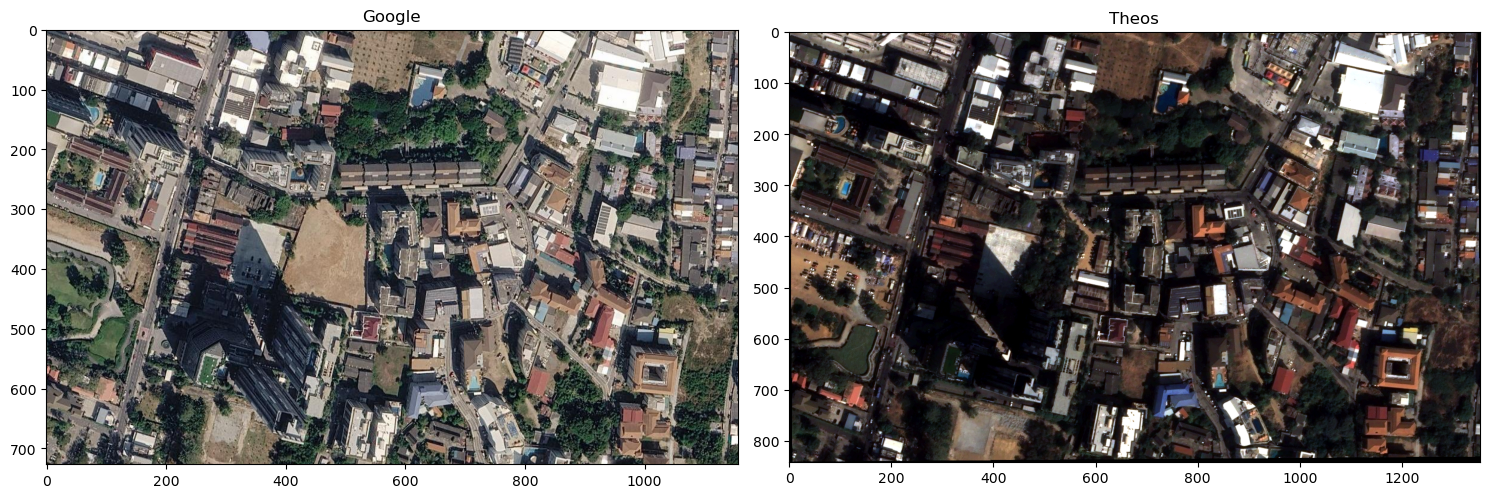

In [12]:
from utils.interactive_tools import Find_correspondences

%matplotlib widget
marker_AB = Find_correspondences(imgA, imgB, figsize=(15, 5))

In [13]:
import cv2

point_src  = np.array(marker_AB.points[0])
point_dst  = np.array(marker_AB.points[1])

Homography, status = cv2.findHomography(point_src, point_dst)



In [14]:
size = (imgB.shape[1], imgB.shape[0])
im_dst = cv2.warpPerspective(imgA, Homography, size) 

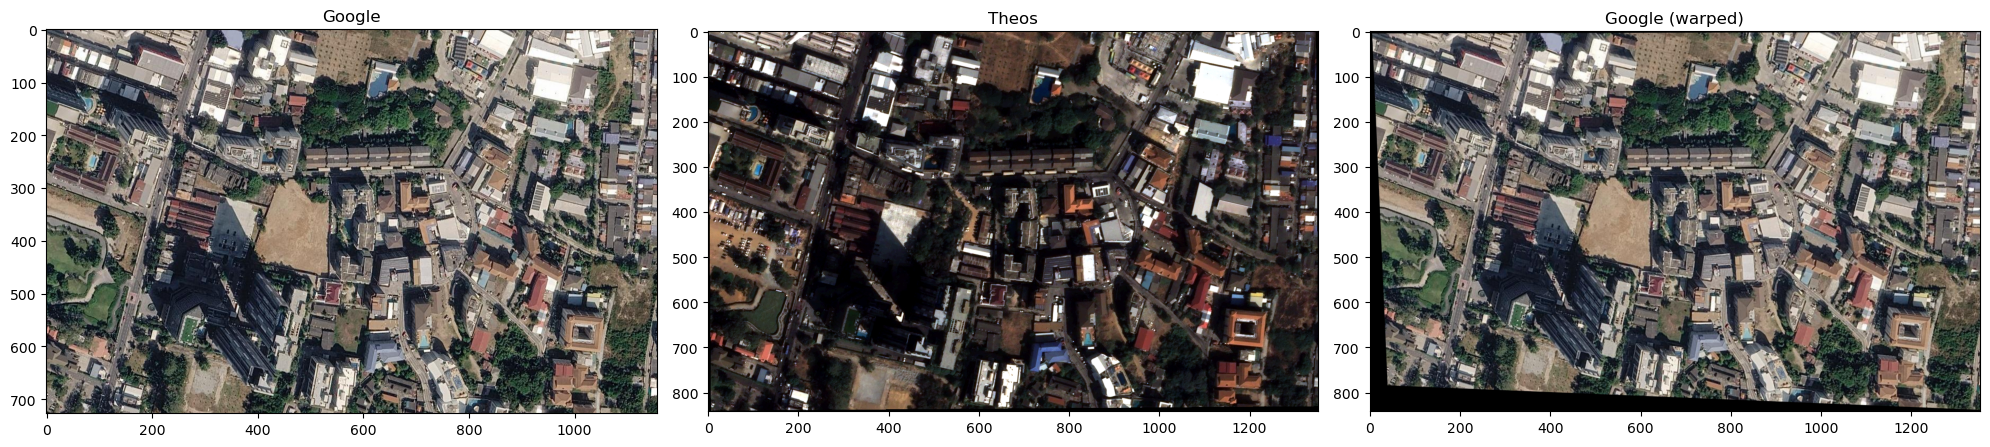

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20,5)) 
axs[0].imshow(imgA[:,:,0:3])  # Display the first three channels (RGB) of the clipped image
axs[0].set_title('Google') # Set a title for the first subplot 

axs[1].imshow(imgB[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[1].set_title('Theos') # Set a title for the second subplot 

axs[2].imshow(im_dst[:,:,0:3])  # Display the first three channels (RGB) of the clipped satellite image
axs[2].set_title('Google (warped)') # Set a title for the second subplot 
 
fig.tight_layout()

In [16]:
im_dst_4D = np.zeros((imgB.shape[0], imgB.shape[1], 4)) 
im_dst_4D[:,:,:3] = im_dst 
im_dst_4D[:,:, 3] = 253
im_dst_4D = im_dst_4D.transpose(2, 0, 1)
im_dst_4D = im_dst_4D.astype(np.uint8)

destination_tif = warped_slice_google_filename
meta_source_tif = slice_theos_filename
save_raster_and_write_meta(im_dst_4D , destination_tif, meta_source_tif)

Modified image saved to : ISP0704-Zoom18/0/warped_google.tif


In [17]:
import leafmap.leafmap as leafmap
m = leafmap.Map()
m.add_raster(slice_google_filename, layer_name="Google") 
m.add_raster(slice_theos_filename, layer_name="theos") 
m.add_raster(warped_slice_google_filename, layer_name="Google (warped)")  
m

Map(center=[12.940595, 100.8895555], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

### Test SamGeo2

In [18]:
from samgeo import SamGeo2 

In [19]:
sam = SamGeo2(
    model_id="sam2-hiera-tiny", 
    automatic=False
)

In [20]:
sam.set_image(warped_slice_google_filename)
sam.show_map()

[ WARN:0@179.067] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 33550 (0x830e) encountered
[ WARN:0@179.067] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 33922 (0x8482) encountered
[ WARN:0@179.067] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 34735 (0x87af) encountered
[ WARN:0@179.067] global grfmt_tiff.cpp:122 TIFF_Warning TIFFReadDirectory: Unknown field with tag 34737 (0x87b1) encountered


Map(center=[12.940595, 100.8895555], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…